## imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
import pickle
import time
import matplotlib.pyplot as plt
import FINDER_core

Using cuda device for FINDER


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## dataset

In [3]:
# Define transformation for input data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the image data
])

In [4]:
# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

In [5]:
# Define data loaders
batch_size = 128 #int(len(train_dataset) / 1000)

# Define data loaders with full batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## FNN class

In [6]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def loss_grad(self, param, inputs, labels, no_grad = False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        '''
        zeroeing gradients
        '''
        torch.nn.utils.vector_to_parameters(param, self.parameters())
        self.zero_grad()
        
        '''
        loss and grads
        '''
        outputs = model(inputs)

        if no_grad == False:
            ls = criterion(outputs, labels)
            ls.backward()
            grads = torch.cat([param.grad.data.view(-1) for param in self.parameters()], dim=0)
            return ls.item(), grads 
            
        else:
            with torch.no_grad():
                ls = criterion(outputs, labels)
                return ls.item()

## create model and loss criteria

In [7]:
model = FNN().to(device)
start = torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone()
criterion = nn.CrossEntropyLoss()
print(len(start), "dimensional problem")

1796010 dimensional problem


## training loop with FINDER

In [8]:
torch.nn.utils.vector_to_parameters(start.clone(), model.parameters())

In [9]:
optimizer = FINDER_core.FINDER(model, clamps = [1e-6, 1e-6], θ = 0.0, γ = 0.1, p = 5)

In [10]:
tic = time.time()
fX_mnist_FINDER = []
for epoch in range(20):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        min_fitness = optimizer.step(inputs, labels)

        running_loss += min_fitness * inputs.size(0)
    running_loss /= len(train_dataset)
    fX_mnist_FINDER.append(running_loss)
    print('Epoch [%d] loss: %.9f' %
          (epoch + 1, running_loss))
toc = time.time()
runtime_FINDER = round(toc-tic)
print("finished training in", toc - tic, "seconds")

Epoch [1] loss: 0.132173667
Epoch [2] loss: 0.012845277
Epoch [3] loss: 0.006121032
Epoch [4] loss: 0.003669659
Epoch [5] loss: 0.002428834
Epoch [6] loss: 0.001520552
Epoch [7] loss: 0.001001258
Epoch [8] loss: 0.000566406
Epoch [9] loss: 0.000282317
Epoch [10] loss: 0.000170571
Epoch [11] loss: 0.000115278
Epoch [12] loss: 0.000097655
Epoch [13] loss: 0.000086487
Epoch [14] loss: 0.000079695
Epoch [15] loss: 0.000074722
Epoch [16] loss: 0.000071050
Epoch [17] loss: 0.000068252
Epoch [18] loss: 0.000066073
Epoch [19] loss: 0.000064171
Epoch [20] loss: 0.000062674
finished training in 536.9005250930786 seconds


## testing accuracy

In [11]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {correct / total * 100} %")

Accuracy on test set: 98.72999999999999 %


In [12]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on train set: {correct / total * 100} %")

Accuracy on train set: 100.0 %


# train with Adam

In [13]:
# model_adam = FNN().to(device)
torch.nn.utils.vector_to_parameters(start.clone(), model.parameters()) #to set same starting point for Adam

In [14]:
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
fX_adam_mnist = []
# Train the model
num_epochs = 100
tic = time.time()
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_adam.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_adam.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)
    print('Epoch [%d] loss: %.9f' %
      (epoch + 1, running_loss/len(train_dataset)))

    fX_adam_mnist.append(running_loss/ len(train_dataset))
toc = time.time()
runtime_adam = round(toc - tic)
print("\n finished training with Adam in ",toc-tic," seconds\n")


Epoch [1] loss: 0.197447526
Epoch [2] loss: 0.081334323
Epoch [3] loss: 0.056221344
Epoch [4] loss: 0.042754750
Epoch [5] loss: 0.036230689
Epoch [6] loss: 0.031145114
Epoch [7] loss: 0.024295093
Epoch [8] loss: 0.025702028
Epoch [9] loss: 0.023368260
Epoch [10] loss: 0.018622641
Epoch [11] loss: 0.021545665
Epoch [12] loss: 0.013329724
Epoch [13] loss: 0.020377376
Epoch [14] loss: 0.014456754
Epoch [15] loss: 0.012884311
Epoch [16] loss: 0.011442860
Epoch [17] loss: 0.015954646
Epoch [18] loss: 0.013474974
Epoch [19] loss: 0.012554698
Epoch [20] loss: 0.012922276
Epoch [21] loss: 0.008432657
Epoch [22] loss: 0.011073029
Epoch [23] loss: 0.015181306
Epoch [24] loss: 0.011798002
Epoch [25] loss: 0.008597059
Epoch [26] loss: 0.007484462
Epoch [27] loss: 0.012363882
Epoch [28] loss: 0.010474702
Epoch [29] loss: 0.011577270
Epoch [30] loss: 0.013251096
Epoch [31] loss: 0.006573462
Epoch [32] loss: 0.011462880
Epoch [33] loss: 0.009856308
Epoch [34] loss: 0.014875112
Epoch [35] loss: 0.0102

In [15]:
# Test the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {correct / total * 100}")

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on train set: {correct / total*100}")

Accuracy on test set: 98.22
Accuracy on train set: 99.92333333333333


# train with LBFGS

In [20]:
# model_LBFGS = FNN().to(device)
torch.nn.utils.vector_to_parameters(start.clone(), model.parameters()) #to set same starting point

In [21]:
optimizer_LBFGS = optim.LBFGS(model.parameters(), lr = 1, line_search_fn="strong_wolfe")

In [22]:
fX_LBFGS_mnist = []
# Train the model
num_epochs = 10
tic = time.time()
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        def closure():
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            return loss
        
        loss = optimizer_LBFGS.step(closure)  # Compute the loss
        running_loss += loss.item() * inputs.size(0)
    print('Epoch [%d] loss: %.10f' %
      (epoch + 1, running_loss/len(train_dataset)))

    fX_LBFGS_mnist.append(running_loss/ len(train_dataset))
toc = time.time()
runtime_lbfgs = round(toc - tic)
print("\n finished training with LBFGS in ",toc-tic," seconds\n")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

# plotting

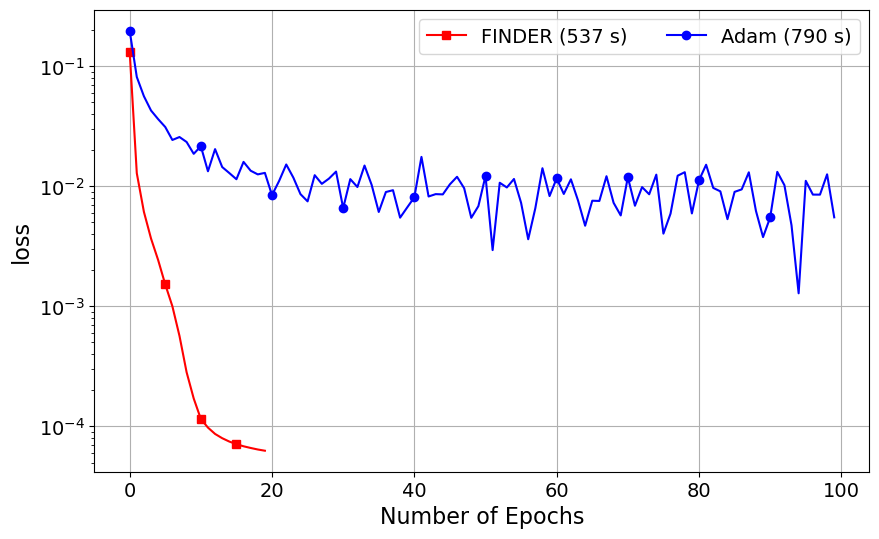

In [16]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fX_mnist_FINDER, 'rs-', markevery= 5, label=f"FINDER ({runtime_FINDER} s)")
plt.plot(fX_adam_mnist, 'bo-', markevery= 10, label=f"Adam ({runtime_adam} s)")
# plt.plot(fx_LBFGS, 'gD-', markevery= 20, label=f"L-BFGS ({runtime_lbfgs} s)")

plt.ylabel('loss', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=16)
plt.legend(loc="best", ncol=3, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.show()

# save data

In [18]:
torch.save(torch.tensor(fX_mnist_FINDER), f'../PlotData/mnist/mnist_FINDER_N{start.shape[0]}_{runtime_FINDER}s.pt')

In [19]:
torch.save(torch.tensor(fX_adam_mnist), f'../PlotData/mnist/mnist_adam_N{start.shape[0]}_{runtime_adam}s.pt')